In [24]:
import sys
sys.path.append('D:\\Users\\serfe\\Desktop\\Maestria geofísica\\1- Semestre 202302\\Inversión sísmica\\999 - Source')
import matplotlib.pyplot as plt
from basic_ops_seis_inv import MathOps
from basic_ops_seis_inv import Filtering
from basic_ops_seis_inv import Error
from basic_ops_seis_inv import ConversionTool
from petro_analysis import DensityAnalysis
from post_stack import poststack_methods as ps_methods
from plot_seis_inv import PlotSeisInv

import numpy as np
import pandas as pd

Final units are always in SI system. You have to make sure all input data has SI units before calculating things.

In [2]:
### Instances
math_ops = MathOps()
filtering = Filtering()
ps_methods = ps_methods()
plot_seis_inv = PlotSeisInv()
error = Error()
density_analysis = DensityAnalysis()
conversion_tool = ConversionTool()

In [3]:
# Original data
vp = np.array([2.27, 2.5, 2.38, 2.4, 2.36]) # km/s
vs = np.array([1.4, 1.5, 1.43, 1.4, 1.41]) # km/s
rho = np.array([2.3, 2.16, 2.19, 2.38, 2.5]) # g/cc3


# SI conversion
vp = conversion_tool.SI_conversion(vp, 'km/s') # m/s
vs = conversion_tool.SI_conversion(vs, 'km/s') # m/s
rho = conversion_tool.SI_conversion(rho, 'g/cc3') # kg/m3

lambda_, mu = math_ops.calc_lame_parameters(rho, vp, vs) # 
print('='*40, 'Lame parameters', '='*40)
print('lambda: ', lambda_)
print('mu: ', mu)

Output units: m/s
Output units: m/s
Output units: kg/m3
======================================== Lame parameters ========================================
lambda:  [2.835670e+09 3.780000e+09 3.448374e+09 4.379200e+09 3.983500e+09]
mu:  [4.508000e+09 4.860000e+09 4.478331e+09 4.664800e+09 4.970250e+09]


In [6]:
def well_logs_2_seismic(rho, lambda_, mu, lambda_wf_initial, lambda_wf_target):
        
        delta = lambda_wf_initial
        depth = np.linspace(1*delta, len(vp)*delta, len(vp))
        n_new_layers = int((len(rho)*lambda_wf_initial)/lambda_wf_target)
        ls_vp0 = []
        ls_vs0 = []
        ls_depth = []
        
        new_depth = np.linspace(0, lambda_wf_target*n_new_layers, n_new_layers+1)
        if new_depth[-1] != depth[-1]:
            new_depth = np.append(new_depth, depth[-1])
        print('old depth', depth)
        print('new depth', new_depth)
        
        z = new_depth
        z2 = depth
        for i in range(len(new_depth)-1):
            
            start = z[i]
            end = z[i+1]
            print(start, end)
            lambda_temp = []
            mu_temp = []
            rho_temp = []
            
            for j in range(len(depth)):
                
                if (z2[j] > start) and (z2[j] <= end):
                    
                    lambda_temp.append(lambda_[j])
                    mu_temp.append(mu[j])
                    rho_temp.append(rho[j])
            
            
            lambda_temp = np.array(lambda_temp)
            mu_temp = np.array(mu_temp)
            rho_temp = np.array(rho_temp)
            
            print(len(lambda_temp), len(mu_temp), len(rho_temp))
            
            # Calculate coefficients
            c = np.mean(1/(lambda_temp + 2*mu_temp))**(-1)
            f = (np.mean(1/(lambda_temp + 2*mu_temp))**(-1))*np.mean(lambda_temp / (lambda_temp + 2*mu_temp))
            l = np.mean(1/mu_temp)**(-1)
            m = np.mean(mu_temp)
                
            # Calculate average velocities
            vp0 = np.sqrt(c/np.mean(rho_temp))
            vs0 = np.sqrt(l/np.mean(rho_temp))
            ls_vp0.append(vp0)
            ls_vs0.append(vs0)

            
        return ls_vp0, ls_vs0, new_depth

In [7]:
lambda_wf_initial, lambda_wf_target = 1,5
vp0, vs0, new_depth = well_logs_2_seismic(rho, lambda_, mu, lambda_wf_initial, lambda_wf_target) # km/s
print('='*35, 'Average wave velocities', '='*35)
print('vp0: ', vp0)
print('vs0: ', vs0)
print('depth: ', new_depth)

old depth [1. 2. 3. 4. 5.]
new depth [0. 5.]
0.0 5.0
5 5 5
=================================== Average wave velocities ===================================
vp0:  [2376.7721242313683]
vs0:  [1425.883471545111]
depth:  [0. 5.]


# Apply it to the dataset of David

In [90]:
dict_names = {1: 'Arenas buenas', 2: 'Arenas buenas sucias', 3: 'Arenas regulares sucias', 4: 'Arenas malas', 5:'Arcillas', -9999: 'Litología desconocida'}
path_data = "D:\\Users\\serfe\\Desktop\\Maestria geofísica\\1- Semestre 202302\\Inversión sísmica\\0 - Tasks\\Ejercicio Sismica de Reflexion II.csv"
df = pd.read_csv(path_data, sep=';')
print(f'Length of original data: {len(df)}')
# Remove outliers from all columns
df = filtering.remove_outliers(df=df[['DEPT', 'RHOB', 'TR', 'VP']], threshold=3)
print(f'Length of filtered data (without outliers): {len(df)}')
# SI concersion
dept = conversion_tool.SI_conversion(df['DEPT'], 'ft')
df['DEPT'] = dept
rhob = conversion_tool.SI_conversion(df['RHOB'], 'g/cc3')
df['RHOB'] = rhob
vp = conversion_tool.SI_conversion(df['VP'], 'ft')
df['VP'] = vp
df['VS'] = math_ops.calc_vs(df['VP'])
### calculate Z and r
df = math_ops.calc_Z(df)
df = math_ops.calc_r(df, 'well')
# calculate DT
df = math_ops.calc_sonic(df, None)

Length of original data: 1928
Length of filtered data (without outliers): 1899
Output units: m
Output units: kg/m3
Output units: m


In [91]:
df

,DEPT,RHOB,TR,VP,VS,Z,r,DT
0,1063.4472,2437.95,5,3040.612867,2633.247986,7.412862e+06,-0.020763,0.000329
1,1063.7520,2430.98,5,2925.281119,2533.367762,7.111300e+06,-0.011869,0.000342
2,1064.0568,2380.59,5,2917.120099,2526.300112,6.944467e+06,-0.010836,0.000343
3,1064.3616,2362.44,4,2876.508852,2491.129740,6.795580e+06,-0.022184,0.000348
4,1064.6664,2316.35,3,2806.403023,2430.416311,6.500612e+06,-0.004246,0.000356
...,...,...,...,...,...,...,...,...
1894,1649.5776,2395.45,3,3271.378776,2833.097125,7.836424e+06,0.014129,0.000306
1895,1649.8824,2399.41,4,3359.593992,2909.493743,8.061043e+06,0.009245,0.000298
1896,1650.1872,2404.28,4,3415.357152,2957.786057,8.211475e+06,-0.000863,0.000293
1897,1650.4920,2384.71,3,3437.446008,2976.915567,8.197312e+06,0.001770,0.000291


In [92]:
lambda_, mu = math_ops.calc_lame_parameters(df['RHOB'], df['VP'], df['VS']) # 
print('='*40, 'Lame parameters', '='*40)
print('lambda: ', lambda_)
print('mu: ', mu)
df['lambda_lame'] = lambda_
df['mu_lame'] = mu

======================================== Lame parameters ========================================
lambda:  0      -1.126982e+10
1      -1.040128e+10
2      -1.012892e+10
3      -9.773772e+09
4      -9.121668e+09
            ...     
1894   -1.281796e+10
1895   -1.354092e+10
1896   -1.402256e+10
1897   -1.408891e+10
1898   -1.402265e+10
Length: 1899, dtype: float64
mu:  0       1.690473e+10
1       1.560191e+10
2       1.519338e+10
3       1.466066e+10
4       1.368250e+10
            ...     
1894    1.922693e+10
1895    2.031137e+10
1896    2.103384e+10
1897    2.113336e+10
1898    2.103397e+10
Length: 1899, dtype: float64


In [93]:
df

,DEPT,RHOB,TR,VP,VS,Z,r,DT,lambda_lame,mu_lame
0,1063.4472,2437.95,5,3040.612867,2633.247986,7.412862e+06,-0.020763,0.000329,-1.126982e+10,1.690473e+10
1,1063.7520,2430.98,5,2925.281119,2533.367762,7.111300e+06,-0.011869,0.000342,-1.040128e+10,1.560191e+10
2,1064.0568,2380.59,5,2917.120099,2526.300112,6.944467e+06,-0.010836,0.000343,-1.012892e+10,1.519338e+10
3,1064.3616,2362.44,4,2876.508852,2491.129740,6.795580e+06,-0.022184,0.000348,-9.773772e+09,1.466066e+10
4,1064.6664,2316.35,3,2806.403023,2430.416311,6.500612e+06,-0.004246,0.000356,-9.121668e+09,1.368250e+10
...,...,...,...,...,...,...,...,...,...,...
1894,1649.5776,2395.45,3,3271.378776,2833.097125,7.836424e+06,0.014129,0.000306,-1.281796e+10,1.922693e+10
1895,1649.8824,2399.41,4,3359.593992,2909.493743,8.061043e+06,0.009245,0.000298,-1.354092e+10,2.031137e+10
1896,1650.1872,2404.28,4,3415.357152,2957.786057,8.211475e+06,-0.000863,0.000293,-1.402256e+10,2.103384e+10
1897,1650.4920,2384.71,3,3437.446008,2976.915567,8.197312e+06,0.001770,0.000291,-1.408891e+10,2.113336e+10


In [94]:
lambda_wf_initial, lambda_wf_target = 0.3048,28
vp0, vs0, new_depth = well_logs_2_seismic(df['RHOB'], df['lambda_lame'], df['mu_lame'], lambda_wf_initial, lambda_wf_target) # km/s
print('='*35, 'Average wave velocities', '='*35)
print('vp0: ', vp0)
print('vs0: ', vs0)
print('depth: ', new_depth)

old depth [3.048000e-01 6.096000e-01 9.144000e-01 ... 5.782056e+02 5.785104e+02
 5.788152e+02]
new depth [  0.      28.      56.      84.     112.     140.     168.     196.
 224.     252.     280.     308.     336.     364.     392.     420.
 448.     476.     504.     532.     560.     578.8152]
0.0 28.0
91 91 91
28.0 56.0
92 92 92
56.0 84.0
92 92 92
84.0 112.0
92 92 92
112.0 140.0
92 92 92
140.0 168.0
92 92 92
168.0 196.0
92 92 92
196.0 224.0
91 91 91
224.0 252.0
92 92 92
252.0 280.0
92 92 92
280.0 308.0
92 92 92
308.0 336.0
92 92 92
336.0 364.0
92 92 92
364.0 392.0
92 92 92
392.0 420.0
91 91 91
420.0 448.0
92 92 92
448.0 476.0
92 92 92
476.0 504.0
92 92 92
504.0 532.0
92 92 92
532.0 560.0
92 92 92
560.0 578.8152
62 62 62
=================================== Average wave velocities ===================================
vp0:  [2789.167334238094, 3004.302268824179, 3097.6713870838553, 3125.377853580761, 3223.6272837021993, 3330.988223000873, 3223.048353300532, 3224.770874109652, 3287.836

In [98]:
old_time = np.linspace(df['DEPT'].min(), df['DEPT'].max(), len(df['DEPT']))
new_time = np.linspace(df['DEPT'].min(), df['DEPT'].max(), len(vp0))

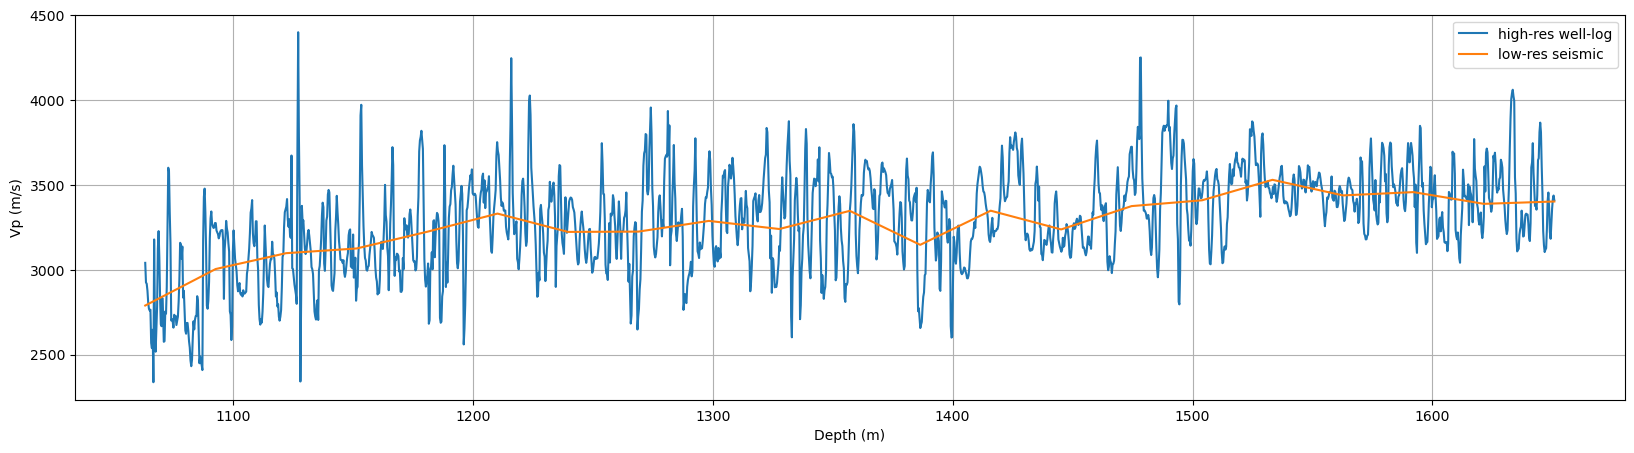

In [99]:
fig = plt.figure(figsize=(20,5))
plt.plot(old_time, df['VP'], label='high-res well-log')
plt.plot(new_time, vp0, label='low-res seismic')
plt.ylabel('Vp (m/s)')
plt.xlabel('Depth (m)')
plt.grid()
plt.legend()

In [97]:
f_original = 1/0.3048 # Hz
f_target = 125 # Hz
v = 3400 # m/s
print(f_original, f_target)
lambda_start = v/f_original 
lambda_end = v/f_target
print(lambda_start, lambda_end)

3.280839895013123 125
1036.3200000000002 27.2


In [79]:
lambda_wf = (df['DEPT'].max() - df['DEPT'].min())/len(vp0)
print(lambda_wf) # m
3400/lambda_wf

27.969028571428574


121.56303503058484

(array([1., 0., 1., 0., 3., 3., 3., 3., 5., 2.]),
 array([2793.21827833, 2866.35895746, 2939.49963659, 3012.64031572,
        3085.78099485, 3158.92167398, 3232.06235311, 3305.20303225,
        3378.34371138, 3451.48439051, 3524.62506964]),
 <BarContainer object of 10 artists>)

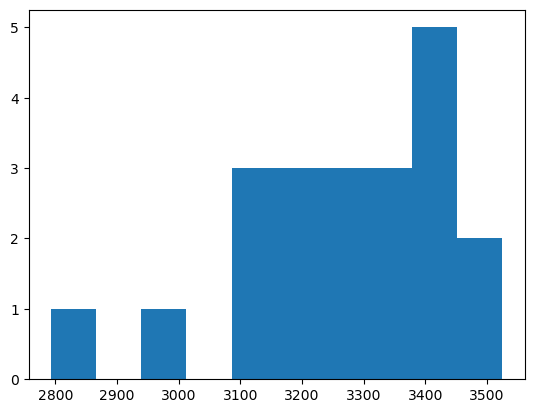

In [78]:
plt.hist(vp0)

(array([ 13.,  67., 138., 361., 508., 523., 219.,  58.,   8.,   4.]),
 array([2337.2316984 , 2543.48123256, 2749.73076672, 2955.98030088,
        3162.22983504, 3368.4793692 , 3574.72890336, 3780.97843752,
        3987.22797168, 4193.47750584, 4399.72704   ]),
 <BarContainer object of 10 artists>)

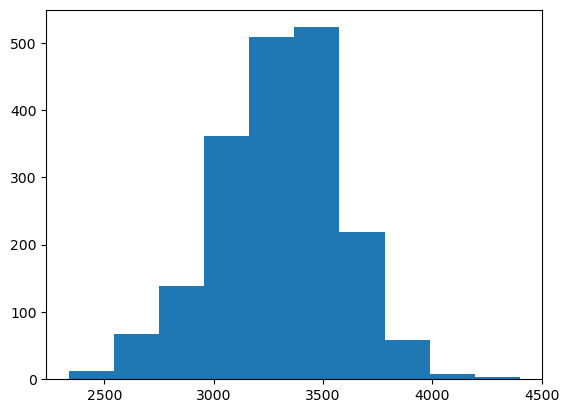

In [69]:
plt.hist(df['VP'])

In [73]:
lambda_wf = (df['DEPT'].max() - df['DEPT'].min())/len(vp0)
print(lambda_wf)

27.969028571428574


In [76]:
vp0

[2793.2182783263543,
 2998.971619788105,
 3103.3003604817072,
 3126.1527053363757,
 3224.913938953942,
 3330.8624406510808,
 3220.967824791975,
 3219.945541131851,
 3297.1391490452606,
 3238.158893347714,
 3343.0524058307565,
 3142.954644714877,
 3351.5195079079153,
 3243.763465304854,
 3387.2871105651684,
 3404.2782600252563,
 3524.625069639246,
 3436.5004644426435,
 3452.148966407079,
 3400.2410091932584,
 3389.8176815856787]

In [71]:
df

,DEPT,RHOB,TR,VP,VS,Z,r,DT,lambda_lame,mu_lame
0,1063.4472,2437.95,5,3040.612867,2633.247986,7.412862e+06,-0.020763,0.000329,-1.126982e+10,1.690473e+10
1,1063.7520,2430.98,5,2925.281119,2533.367762,7.111300e+06,-0.011869,0.000342,-1.040128e+10,1.560191e+10
2,1064.0568,2380.59,5,2917.120099,2526.300112,6.944467e+06,-0.010836,0.000343,-1.012892e+10,1.519338e+10
3,1064.3616,2362.44,4,2876.508852,2491.129740,6.795580e+06,-0.022184,0.000348,-9.773772e+09,1.466066e+10
4,1064.6664,2316.35,3,2806.403023,2430.416311,6.500612e+06,-0.004246,0.000356,-9.121668e+09,1.368250e+10
...,...,...,...,...,...,...,...,...,...,...
1894,1649.5776,2395.45,3,3271.378776,2833.097125,7.836424e+06,0.014129,0.000306,-1.281796e+10,1.922693e+10
1895,1649.8824,2399.41,4,3359.593992,2909.493743,8.061043e+06,0.009245,0.000298,-1.354092e+10,2.031137e+10
1896,1650.1872,2404.28,4,3415.357152,2957.786057,8.211475e+06,-0.000863,0.000293,-1.402256e+10,2.103384e+10
1897,1650.4920,2384.71,3,3437.446008,2976.915567,8.197312e+06,0.001770,0.000291,-1.408891e+10,2.113336e+10
